# ConvLSTM 
> Conv lstm model

In [1]:
from fastai.vision.all import *
from action_recognition.core import *
from action_recognition.models import *

In [2]:
set_seed(2021)

In [3]:
torch.cuda.set_device(1)
torch.cuda.get_device_name()

RuntimeError: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver.

In [4]:
data_path = Path.home()/'.fastai/data/UCF101-frames'

In [5]:
instances = get_instances(data_path)

## Params

In [6]:
seq_len = 20
step=5
image_size = 128
bs = 16
val_idxs = None

you could put this split on a text file:

In [7]:
dls = get_action_dataloaders(instances, bs=bs, image_size=image_size, seq_len=seq_len, step=step, val_idxs=val_idxs)

/home/pmishra/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/pmishra/.local/lib/python3.8/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


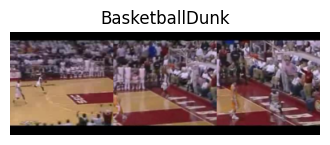

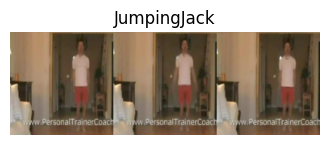

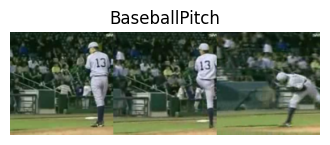

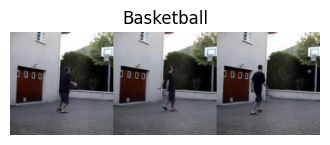

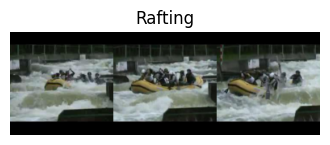

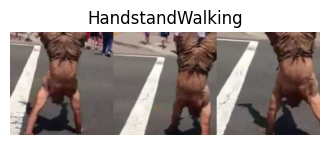

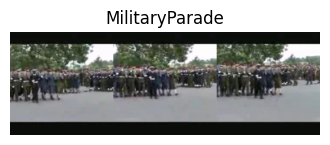

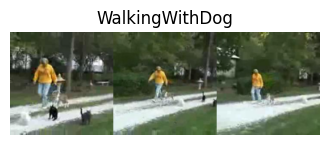

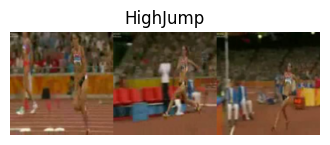

In [8]:
dls.show_batch()

## Train without attention
> We will predict over the hidden state of the sequence.

In [9]:
model = ConvLSTM(num_classes=dls.c, hidden_dim=256, lstm_layers=2, bidirectional=False, attention=False)

/home/pmishra/.local/lib/python3.8/site-packages/fastai/vision/learner.py:295: UserWarning: `create_cnn_model` has been renamed to `create_vision_model` -- please update your code
  warn("`create_cnn_model` has been renamed to `create_vision_model` -- please update your code")


In [10]:
learn = Learner(dls, model, metrics=[accuracy, top_k_accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter).to_fp16()
learn.freeze()

SuggestedLRs(valley=0.0008317637839354575)

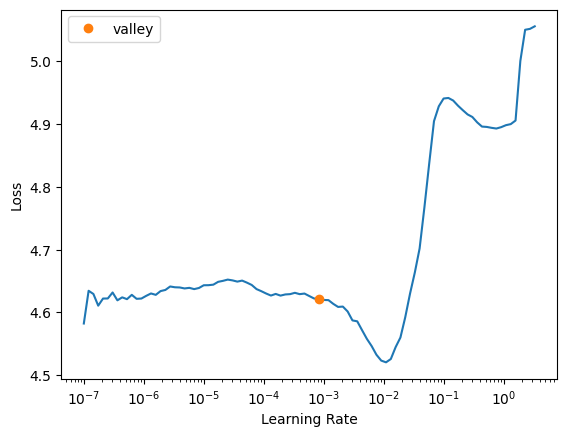

In [11]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10, 5e-3)

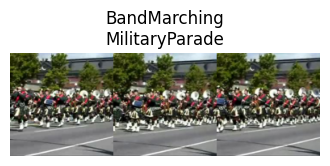

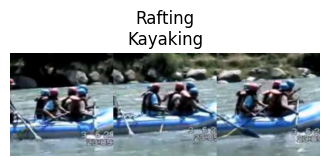

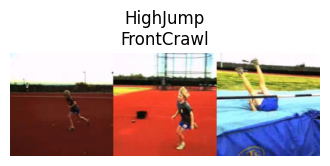

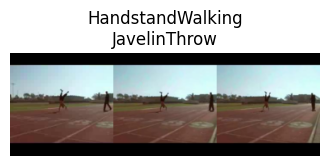

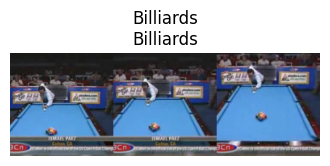

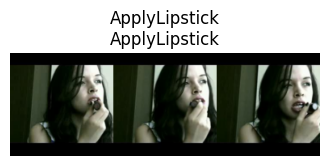

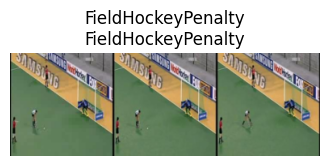

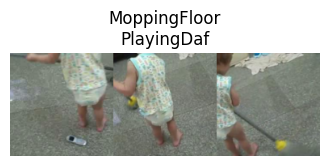

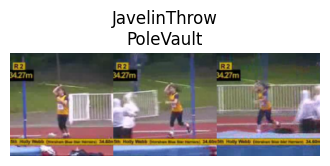

In [13]:
learn.show_results()

In [17]:
learn.validate()

(#3) [1.1331373453140259,0.6734234094619751,0.9140390157699585]

## Train with attention
> We will predict with an attention layer over the full output sequence from the LSTM layer.

In [14]:
model2 = ConvLSTM(num_classes=dls.c, hidden_dim=256, lstm_layers=2, bidirectional=True, attention=True)

In [15]:
learn2 = Learner(dls, model2, metrics=[accuracy, top_k_accuracy], wd=0.1, cbs=[ModelResetter()], splitter=convlstm_splitter).to_fp16()
learn2.freeze()

SuggestedLRs(valley=0.00363078061491251)

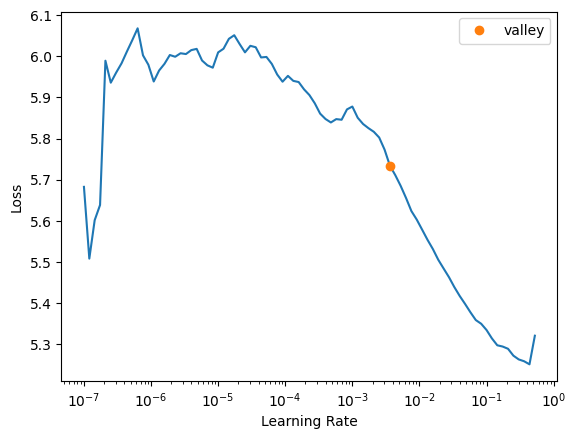

In [18]:
learn2.lr_find()

In [19]:
learn2.fit_one_cycle(10, 5e-3)

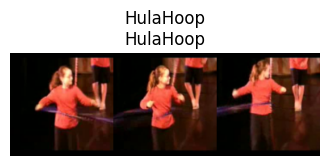

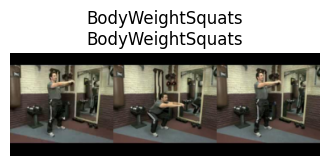

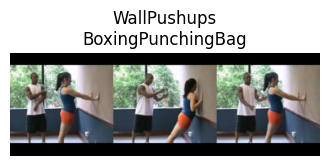

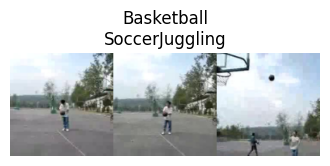

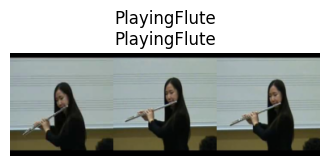

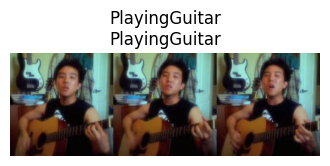

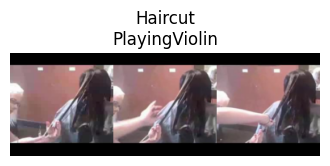

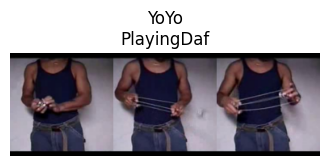

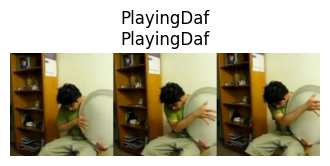

In [20]:
learn2.show_results()

In [21]:
learn2.validate()

(#3) [1.4013921022415161,0.5979729890823364,0.8795045018196106]